<a href="https://colab.research.google.com/github/vicdlp/CS_project/blob/main/CS_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries:

In [2]:
!pip install biopython # Install the biopython library which contains the SeqIO module.
from Bio import SeqIO # to read protein sequences
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import stats
import re

# Set plot style for a cleaner visual appearance
plt.style.use('seaborn-v0_8')

# Set the fontsize for various plot elements
plt.rcParams.update({
    'font.size': 20,            # General font size
    'axes.titlesize': 22,       # Title font size
    'axes.labelsize': 20,       # Axis label font size
    'xtick.labelsize': 18,      # X-tick label font size
    'ytick.labelsize': 18,      # Y-tick label font size
    'legend.fontsize': 18,      # Legend font size
    'figure.figsize': (12, 8),  # Set default figure size to 16x9
    'legend.frameon': True,
    'legend.edgecolor' : '0.1'
})


# Task 1 : Pre-processing of data and One-Hot encoding

  After reading the data from the ".fasta" files, the goal is to convert the protein sequences of our data set into variables that will be easier to manipulate numerically. The sequences are made of the 20 amino-acids (AA), and the alignment gap "-". They are of the form, for example : "--ATHG--MPPQR...", and are each of length 96.


  The first idea would be to associate a value to each AA and to store the sequence in a 96 dimensional vector. However this would create a distance relationship between amino-acids, because the AA labeled with 20 would be much closer (for the computer that didn't study biology) to the one labeled 19, than to the one labeled with 1, which is not true in reality, because there is no order relationship between AA (they are just the elementary bricks of a sequence, and labeling them with another number shouldn't change their relationships).

  Therefore, we must use one-hot encoding, which consist to uniquely associate each AA, not with a number, but with one of the 21 vectors of the canonical basis of $\mathbb{R}^{21}$. This keeps all the AAs equidistant (for Euclidean distance, for example, $\sqrt{2}$). But our sequences are 96 AA long, so if we want to store each sequence as a datapoint, we must store it in a $21\times 96 = 2016$-dim vector.

  This is the content of the following sequences

In [3]:
nat = list(SeqIO.parse("MSA_nat_with_annotation.faa", "fasta")) # Natural data sampled from experiments

art = list(SeqIO.parse("MSA_art.faa", "fasta")) # Artificial data sampled from the generative model

In [4]:
def one_hot(sequence): # Converts a single sequence of length 96 to a 96 x 21 = 2016 dimensional vector

  matrix = np.zeros((21,96)) # matrix to store the encoded data

  # Dictionary that converts amino-acids to a number between 0 and 20
  amino_acids = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K':8, 'L':9, 'M':10, 'N':11, 'P':12, 'Q':13, 'R':14, 'S':15, 'T':16, 'V':17, 'W':18, 'Y':19, '-':20}

  for i in range(96): # for the i-th amino-acid of the sequence ...
    matrix[amino_acids[sequence[i]], i] = 1 # ... associate the corresponding 21 dim vector in column i

  return matrix.flatten() # return the flatten matrix to get the data-point as a vector



def encode(data): # Converts the dataset to a matrix containing the one-hot encoded sequences

  matrix = np.zeros((len(data),2016))

  for i in range(len(data)):
    matrix[i] = one_hot(data[i].seq)

  return matrix



def label(data): # Extracts the labels of the dataset : Functional sequence (y=1) or Non Functional sequence (y=0)
  label = np.zeros(len(data))
  for i in range(len(data)):
    if re.search(r"functional_true", data[i].description):
      label[i] = 1
    else:
      label[i] = 0

  return label

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Rescaling the data : x' = (x-mu)/sigma     (seems not necessary here ?)

# Natural sequences dataset
X = encode(nat)
x = label(nat)

scaler.fit(X)
X = scaler.transform(X)

# Artificial sequences dataset
Y = encode(art)
y = label(art)

scaler.fit(Y)
Y = scaler.transform(Y)

# Task 2 : Principal Component Analysis

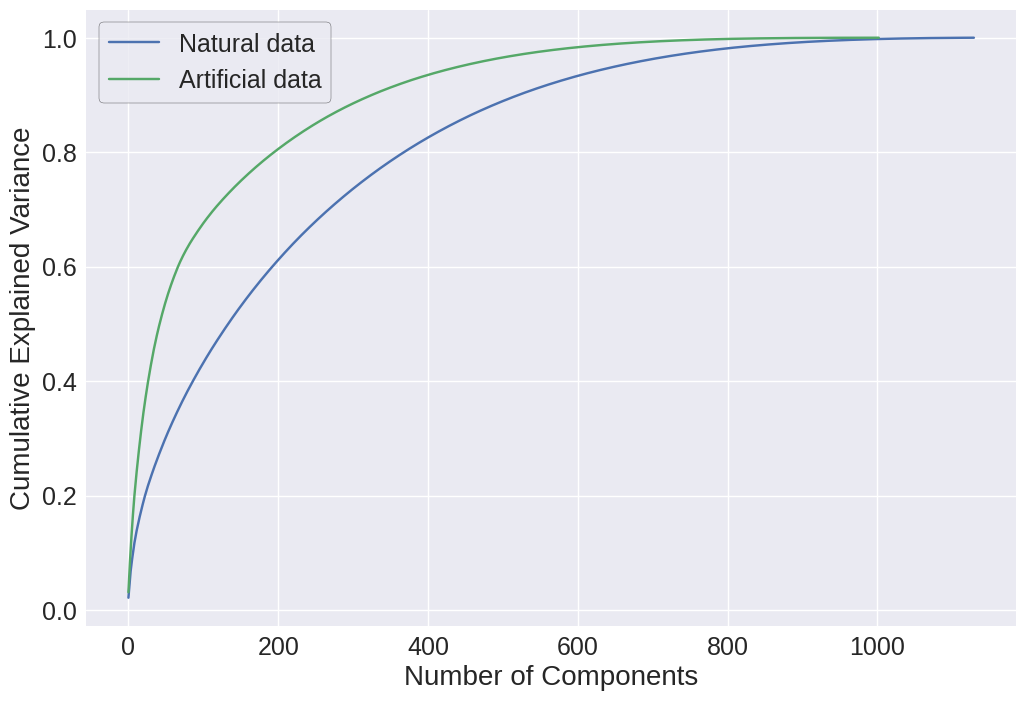

In [6]:
# Fit PCA without specifying the number of components to compute variance ratios for all components
pca = PCA().fit(X)
pca_nat = PCA().fit(Y)

# Plot the cumulative explained variance as a function of the number of components
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), label = "Natural data")  # Cumulative sum of explained variance
plt.plot(np.cumsum(pca_nat.explained_variance_ratio_), label = "Artificial data")
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

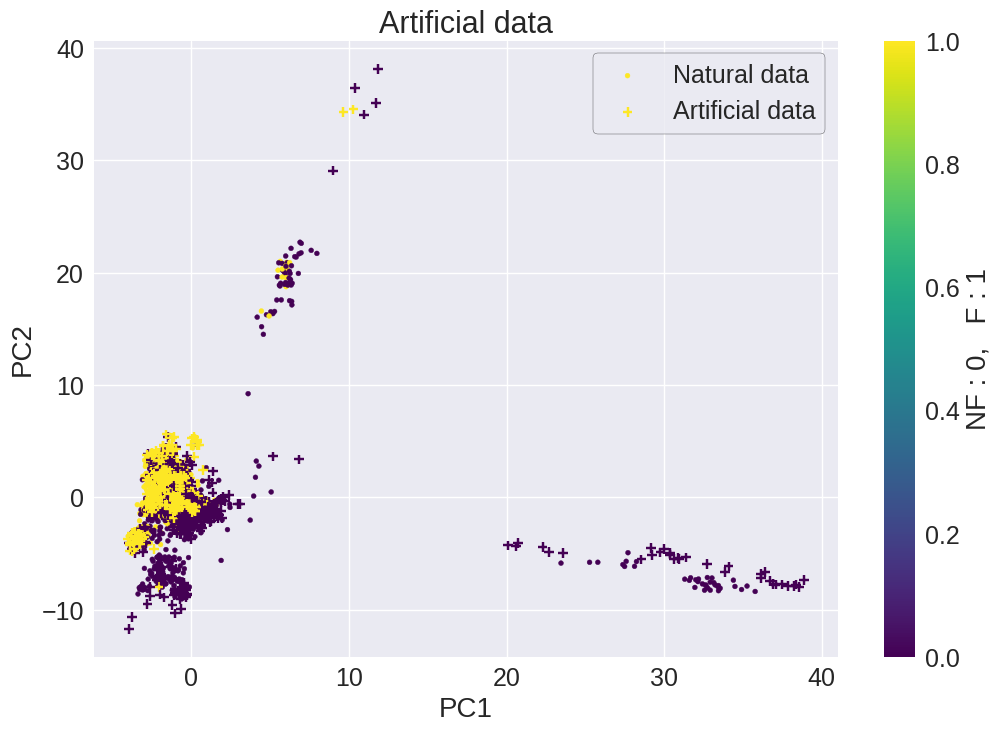

In [7]:
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X) # Finding the 2 PCs of the Natural data and projecting the data onto them
Y_pca = pca.transform(Y) # Projecting the Artificial data on the 2 PCs of the Natural data

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=x, cmap='viridis', label = "Natural data", marker = ".")

plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=y, cmap='viridis', label = "Artificial data", marker = "+")

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Artificial data')
plt.colorbar(label=r'NF : 0,   F : 1')
plt.show()

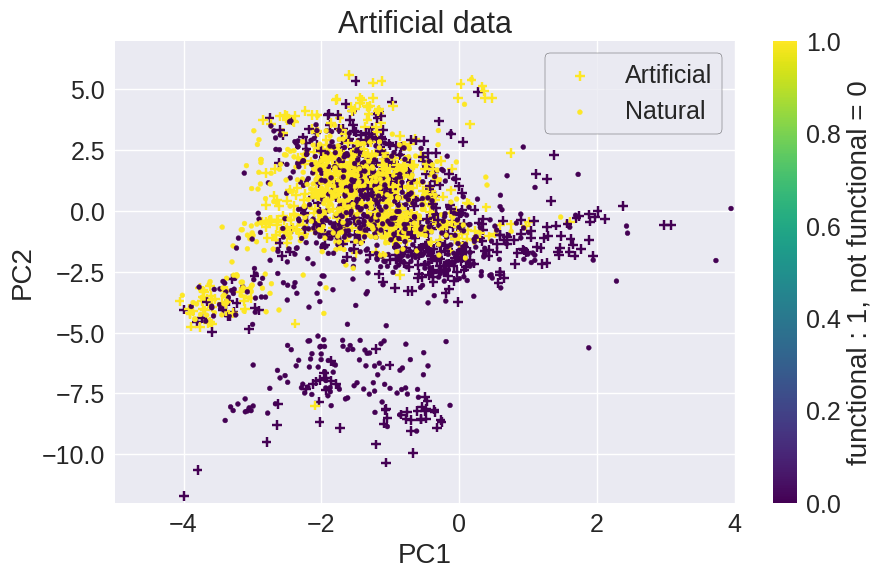

In [8]:
# Zoom on the cloud of points

plt.figure(figsize=(10, 6))

plt.xlim(-5,4)
plt.ylim(-12,7)

plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=y, cmap='viridis', label = "Artificial", marker = "+")
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=x, cmap='viridis', label = "Natural", marker = ".")

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Artificial data')
plt.colorbar(label=r'functional : 1, not functional = 0')
plt.show()

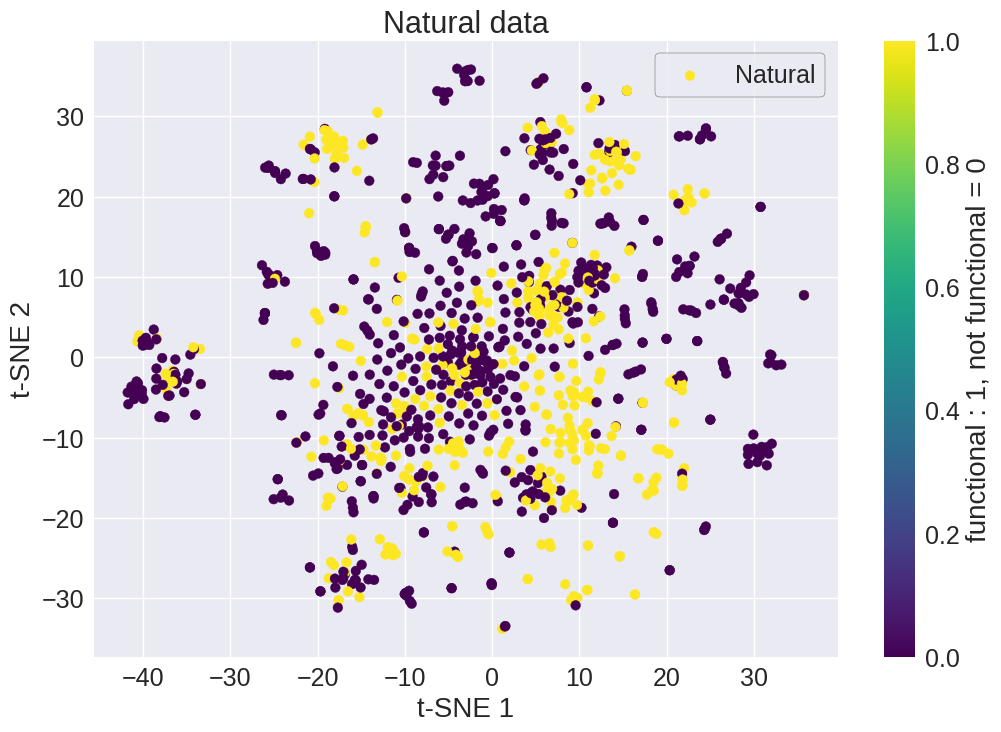

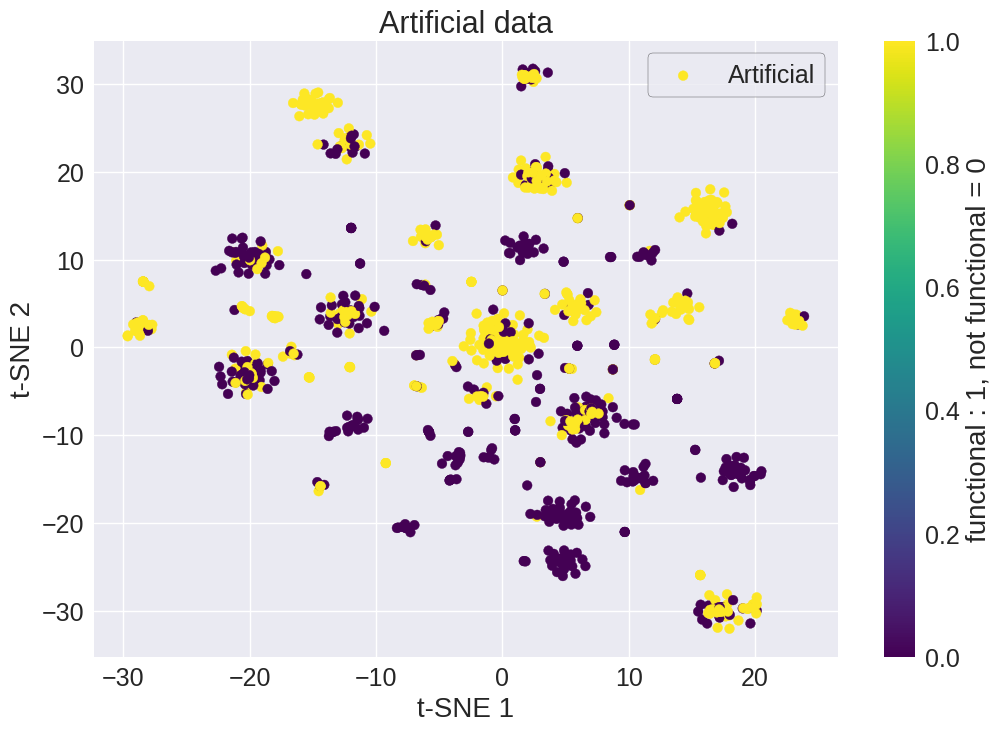

In [9]:
from sklearn.manifold import TSNE

# Initialize t-SNE to reduce the dimensionality to 2 components with a specified perplexity
tsne = TSNE(n_components=2, perplexity=50)

# Apply t-SNE to the data
X_embedded = tsne.fit_transform(X)
Y_embedded = tsne.fit_transform(Y)

# Create a scatter plot of the t-SNE transformed data
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = x, cmap='viridis', label = "Natural")
plt.colorbar(label=r'functional : 1, not functional = 0')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Natural data')
plt.legend()
plt.show()

plt.scatter(Y_embedded[:, 0], Y_embedded[:, 1], c = y, cmap='viridis', label = "Artificial")
plt.colorbar(label=r'functional : 1, not functional = 0')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Artificial data')
plt.legend()
plt.show()

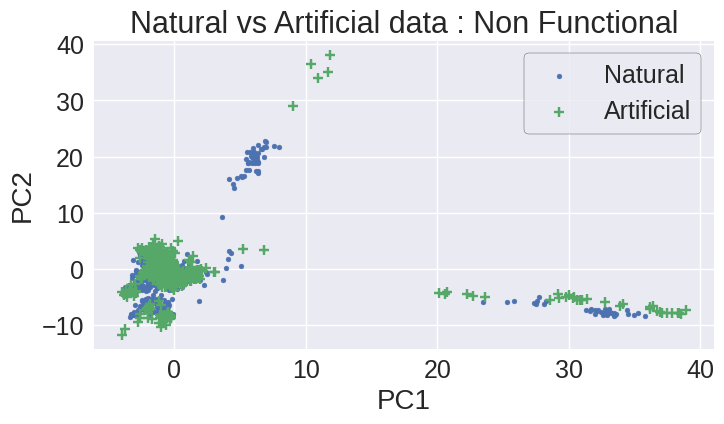

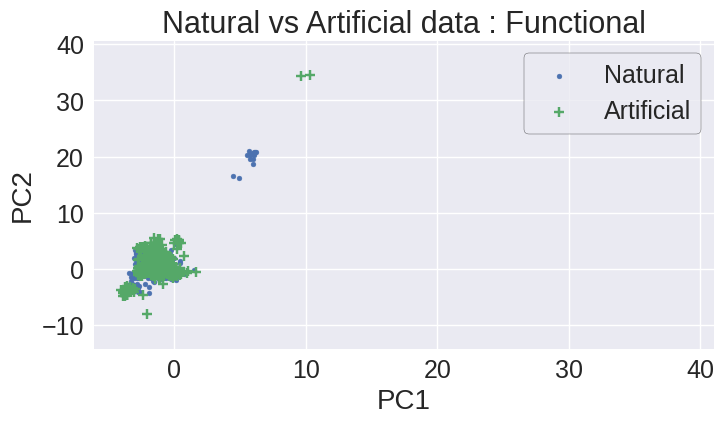

In [10]:
plt.figure(figsize = (8,4))

# Filter the data points where the label is 0
X_pca_label0 = X_pca[x == 0]
Y_pca_label0 = Y_pca[y == 0]

# Plot only the filtered points
plt.scatter(X_pca_label0[:, 0], X_pca_label0[:, 1], label='Natural', marker = ".")
plt.scatter(Y_pca_label0[:, 0], Y_pca_label0[:, 1], label='Artificial', marker = "+")

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Natural vs Artificial data : Non Functional')

x_range = plt.gca().get_xlim()
y_range = plt.gca().get_ylim()

plt.show()


plt.figure(figsize = (8,4))

plt.xlim(x_range)
plt.ylim(y_range)

# Filter the data points where the label is 0
X_pca_label0 = X_pca[x == 1]
Y_pca_label0 = Y_pca[y == 1]

# Plot only the filtered points
plt.scatter(X_pca_label0[:, 0], X_pca_label0[:, 1], label='Natural', marker = ".")
plt.scatter(Y_pca_label0[:, 0], Y_pca_label0[:, 1], label='Artificial', marker = "+")

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Natural vs Artificial data : Functional')

x_range = plt.gca().get_xlim()
y_range = plt.gca().get_ylim()

plt.show()

# Task 3 Clustering


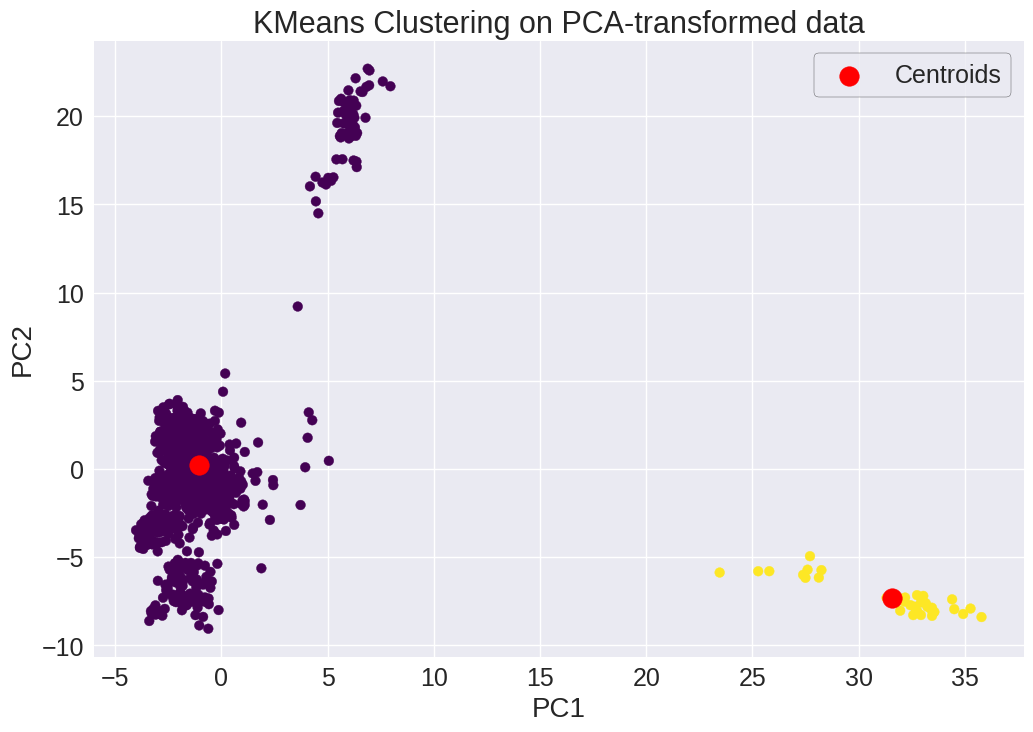

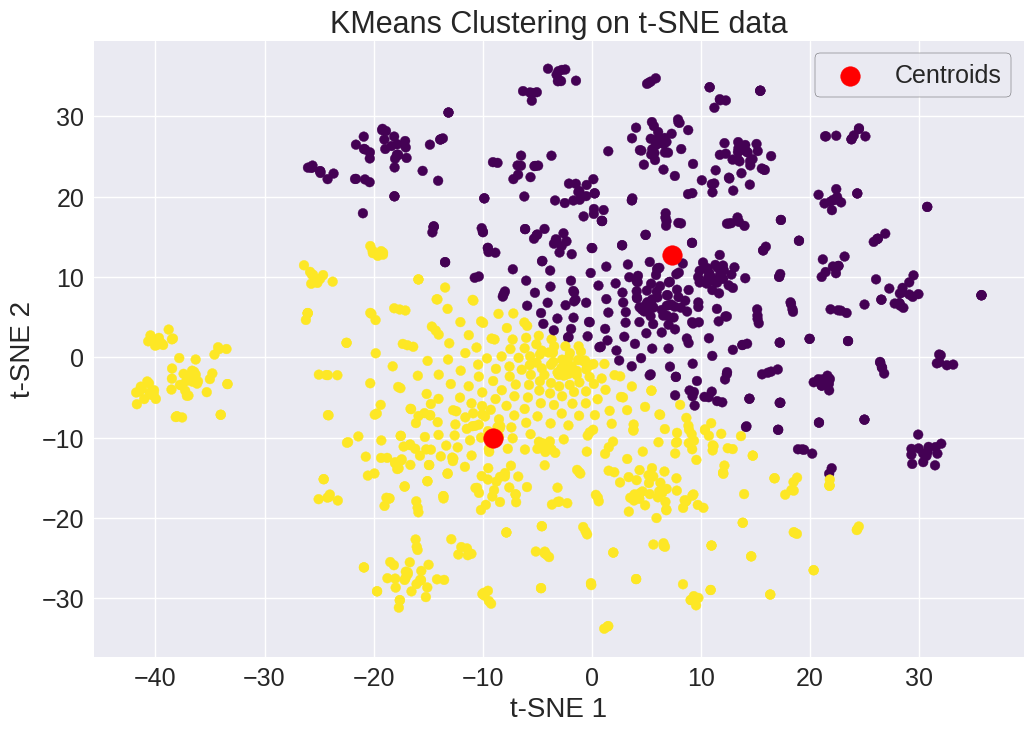

In [11]:
# prompt: clustering algorithm for the natural data

from sklearn.cluster import KMeans

# Apply KMeans clustering to the PCA-transformed data
kmeans = KMeans(n_clusters=2, random_state=0)  # Initialize KMeans with 2 clusters
kmeans.fit(X_pca)  # Fit KMeans to the PCA-transformed data

# Get cluster labels for each data point
labels_pca = kmeans.labels_

# Visualize the clusters
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pca, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering on PCA data')
plt.legend()
plt.show()

# Similarly for the t-SNE data
kmeans_tsne = KMeans(n_clusters=2, random_state=0)
kmeans_tsne.fit(X_embedded)
labels_tsne = kmeans_tsne.labels_

plt.figure()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_tsne, cmap='viridis')
plt.scatter(kmeans_tsne.cluster_centers_[:, 0], kmeans_tsne.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('KMeans Clustering on t-SNE data')
plt.legend()
plt.show()